# Analysis

Now that we have our data properly cleaned, we can proceed with the analysis.

As usual, we'll start by importing the necessary libraries and loading our dataset in a variable named 'data'.

In [14]:
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../src')
from analysis_utils import club_filtering

After loading our dataset, we have to correct some data types, datetimes specifically

In [3]:
data = pd.read_csv('../data/processed/fifa_processed.csv')
data['Contract Valid Until'] = pd.to_datetime(data['Contract Valid Until'])
data['Joined'] = pd.to_datetime(data['Joined'])

In [4]:
data.head()

,Name,Age,Nationality,Overall,Potential,International Reputation,Club,Wage (K_EUR),Preferred Foot,Weak Foot,Position,Position_Group,Jersey Number,Height_cm,Weight_kg,Joined,Contract Valid Until,Release Clause (M_EUR)
0,L. Messi,31,Argentina,94,94,5,FC Barcelona,565.0,Left,4,RF,ATT,10,170.18,72.12,2004-07-01,2021-12-31,226.5
1,Cristiano Ronaldo,33,Portugal,94,94,5,Juventus,405.0,Right,4,ST,ATT,7,187.96,83.01,2018-07-10,2022-12-31,127.1
2,Neymar Jr,26,Brazil,92,93,5,Paris Saint-Germain,290.0,Right,5,LW,ATT,10,175.26,68.04,2017-08-03,2022-12-31,228.1
3,De Gea,27,Spain,91,93,4,Manchester United,260.0,Right,3,GK,GK,1,193.04,76.20,2011-07-01,2020-12-31,138.6
4,K. De Bruyne,27,Belgium,91,92,4,Manchester City,355.0,Right,5,RCM,MDF,7,180.34,69.85,2015-08-30,2023-12-31,196.4


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18147 entries, 0 to 18146
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Name                      18147 non-null  object        
 1   Age                       18147 non-null  int64         
 2   Nationality               18147 non-null  object        
 3   Overall                   18147 non-null  int64         
 4   Potential                 18147 non-null  int64         
 5   International Reputation  18147 non-null  int64         
 6   Club                      18147 non-null  object        
 7   Wage (K_EUR)              18147 non-null  float64       
 8   Preferred Foot            18147 non-null  object        
 9   Weak Foot                 18147 non-null  int64         
 10  Position                  18147 non-null  object        
 11  Position_Group            18147 non-null  object        
 12  Jersey Number     

In [6]:
data.describe()

,Age,Overall,Potential,International Reputation,Wage (K_EUR),Weak Foot,Jersey Number,Height_cm,Weight_kg,Joined,Contract Valid Until,Release Clause (M_EUR)
count,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147,18147,18147.000000
mean,25.121122,66.253926,71.324076,1.113297,9.759024,2.947154,19.546096,181.259450,75.287940,2017-01-20 18:42:26.007604480,2021-01-30 22:35:00.843114496,4.205057
min,16.000000,46.000000,48.000000,1.000000,0.000000,1.000000,1.000000,154.940000,49.900000,1991-06-01 00:00:00,2018-11-30 00:00:00,0.000000
25%,21.000000,62.000000,67.000000,1.000000,1.000000,3.000000,8.000000,175.260000,69.850000,2016-07-01 00:00:00,2019-12-31 00:00:00,0.398000
50%,25.000000,66.000000,71.000000,1.000000,3.000000,3.000000,17.000000,180.340000,74.840000,2017-07-24 00:00:00,2020-12-31 00:00:00,1.000000
75%,28.000000,71.000000,75.000000,1.000000,9.000000,3.000000,26.000000,185.420000,79.830000,2018-07-01 00:00:00,2021-12-31 00:00:00,3.000000
max,45.000000,94.000000,95.000000,5.000000,565.000000,5.000000,99.000000,205.740000,110.220000,2019-01-31 00:00:00,2026-12-31 00:00:00,228.100000
std,4.669796,6.913320,6.132286,0.394150,22.030250,0.660498,15.947765,6.730335,7.073234,NaN,NaN,10.722751


## Creating metrics

We'll start our analysis by creating some derived metrics will allow you to find business patterns and sports efficiency far beyond basic statistics. This metrics are:

* **Value/Potential Efficiency:** helps identifying underrated players or with a bigger profit margin. Allow to find young promising players whose market value is below its potential future value. Scouting type analysis.

    * Value/Potential Efficiency = Release Clause (M_EUR) / Potential

    * We will look for players with a low metric here (cheap players in relation to its potential).

* **Wage-to-Performance Ratio:** measures the cost of each performance point from every player in the same club. Reveals which clubs are overpaying players who have passed its peak or what field positions (ex: attackers vs midfielders) have higher ability cost within the market.

    * Wage-to-Performance Ratio = Wage (K_EUR) / Overall

    * We will look for players with a low metric here (low wages in relation to its overall).

* **Growth Margin:** measures growth margin for each player. Combined with Age, we can categorize clubs in slots like 'Future projects' (high margin, low age) or 'Veteran Teams' (low margin, high age) calculating a **Club Maturity Index**.

    * Growth Margin = Potential - Overall

    * We will look for players with high growth margin (brither future in their horizon).

    * **Club Maturity Index** = (Growth Margin).mean() / Age.mean()

* **Days Left:** helps identifying players in its lasts contract year, which usually implies a lower market value or signing oportunities. Present day will be 01/01/2018.

    * Days Left = Contract Valid Until - Present day

In [4]:
# We won't find players with 0 Potential or Overall
# But we will control divisions by 0, just in case
data['Value/Potential Efficiency'] = np.where(data['Potential'] > 0, 
                                              round(data['Release Clause (M_EUR)'] / data['Potential'], 3),
                                              np.nan)
data['Wage-to-performance Ratio'] = np.where(data['Overall'] > 0, 
                                             round(data['Wage (K_EUR)'] / data['Overall'], 3),
                                             np.nan)
data['Growth Margin'] = data['Potential'] - data['Overall']
data['Days Left'] = (data['Contract Valid Until'] - pd.to_datetime('Jan 01, 2018')).dt.days

In [8]:
data.head()

,Name,Age,Nationality,Overall,Potential,International Reputation,Club,Wage (K_EUR),Preferred Foot,Weak Foot,...,Jersey Number,Height_cm,Weight_kg,Joined,Contract Valid Until,Release Clause (M_EUR),Value/Potential Efficiency,Wage-to-performance Ratio,Growth Margin,Days Left
0,L. Messi,31,Argentina,94,94,5,FC Barcelona,565.0,Left,4,...,10,170.18,72.12,2004-07-01,2021-12-31,226.5,2.410,6.011,0,1460
1,Cristiano Ronaldo,33,Portugal,94,94,5,Juventus,405.0,Right,4,...,7,187.96,83.01,2018-07-10,2022-12-31,127.1,1.352,4.309,0,1825
2,Neymar Jr,26,Brazil,92,93,5,Paris Saint-Germain,290.0,Right,5,...,10,175.26,68.04,2017-08-03,2022-12-31,228.1,2.453,3.152,1,1825
3,De Gea,27,Spain,91,93,4,Manchester United,260.0,Right,3,...,1,193.04,76.20,2011-07-01,2020-12-31,138.6,1.490,2.857,2,1095
4,K. De Bruyne,27,Belgium,91,92,4,Manchester City,355.0,Right,5,...,7,180.34,69.85,2015-08-30,2023-12-31,196.4,2.135,3.901,1,2190


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18147 entries, 0 to 18146
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Name                        18147 non-null  object        
 1   Age                         18147 non-null  int64         
 2   Nationality                 18147 non-null  object        
 3   Overall                     18147 non-null  int64         
 4   Potential                   18147 non-null  int64         
 5   International Reputation    18147 non-null  int64         
 6   Club                        18147 non-null  object        
 7   Wage (K_EUR)                18147 non-null  float64       
 8   Preferred Foot              18147 non-null  object        
 9   Weak Foot                   18147 non-null  int64         
 10  Position                    18147 non-null  object        
 11  Position_Group              18147 non-null  object    

# Scouting process

In our first analysis, we will perform an scouting process. Our goal is to identify signing opportunities (high potential players with low economic cost). To do so, we will use the following guidelines based on the metrics we have created:

* We will use Value/Potential Efficiency to identify players with high potential and low signing costs.

* We will use Wage-to-performance Ratio to identify players whoe don't earn so much in relation to their performance.

* We will use Growth Margin and Age to identify young players who can become solid proffesionals.

* We will use Contract remaining to identify players with contracts nearing expiration date, which are usually easier to sign.

Combining this four guidelines, we will produce a dataset containing interesting signing opportunities.

A few thing to take into consideration before starting the scouting process:

* **Tier segmentation:** it is not the same searching for a bargaig for elite teams than doing it por second division ones. It could be usefull to use different tiers for our analysis based on Potential intervals (ex: Tier Elite > 85, Tier Promise 75-84).

* **Quality Floor Filter:** in order to discard players with a very low performance score but interesting in economics terms (cheap, but not suitable for professional level), we could add an Overall minimun (ex: Overall > 65).

* **Applying scoring:** we could create an 'Scouting Score' for each player. By doing this instead of simply filtering, we could still retrieve interesting players with one metric above the usual.

### Scouting Algorithm

We will implement a succesive filtering method with final ranking:

1. Creating hard filters (players who don't fit into future investment):
    
    1.1. Age filter (Age <= 24): players usually reach their peak around 28 years old. This way we ensure their groth margin can be reached.

    1.2. Minimum Quality filter (Potential >= 65): only players who will become notable.

    1.3. Contract filter (Contract Remaining <= 730): less than 2 years in their current contrat to ensure pressure in the negotiation. 

2. Create the ranking (scoring). As each metric has its own different scale, the ideal is using percentiles for calculating their global score.

3. Classify players in different tiers and rank them globally and within their tier.

In [5]:
# 1. Applying hard filters"
scouting_pool = data[(data['Age'] <= 24) & 
                     (data['Potential'] >= 65) & 
                     (data['Days Left'] <= 730)].copy()

# 2. Making metric comparables by normalization (0 to 1)
# In Efficiency and Wage we look for the MINIMUM, so we substract from 1
scouting_pool['score_value'] = 1 - scouting_pool['Value/Potential Efficiency'].rank(pct=True)
scouting_pool['score_wage'] = 1 - scouting_pool['Wage-to-performance Ratio'].rank(pct=True)
scouting_pool['score_growth'] = scouting_pool['Growth Margin'].rank(pct=True)
scouting_pool['score_contract'] = 1 - scouting_pool['Days Left'].rank(pct=True)

# 3. Combining in "Final Scouting Score"
# We can modify the weight as wanted (ex: prioritize Potential and Growth)
scouting_pool['Final_Scouting_Score'] = (
    scouting_pool['score_value'] * 0.4 + 
    scouting_pool['score_growth'] * 0.3 + 
    scouting_pool['score_wage'] * 0.2 + 
    scouting_pool['score_contract'] * 0.1
)

# 4. Defining categories by Potential
def categorize_potential(potential):
    if potential >= 85:
        return 'Elite Player'
    elif potential >= 75:
        return 'Top Class Player'
    else:
        return 'Great Player'

scouting_pool['Tier'] = scouting_pool['Potential'].apply(categorize_potential)

# 5. Generate Rankings
# Global Ranking: The 1 is the best score within the pool
scouting_pool['Global_Rank'] = scouting_pool['Final_Scouting_Score'].rank(ascending=False, method='min').astype(int)

# Category Rank: The 1 is the best score within the category
scouting_pool['Tier_Rank'] = scouting_pool.groupby('Tier')['Final_Scouting_Score'].rank(ascending=False, method='min').astype(int)

# 6. Order to visualization
scouting_results = scouting_pool.sort_values(['Tier', 'Tier_Rank'])

# 7. Saving the results in case we use it later
scouting_results.to_csv('../data/processed/scouting_results.csv')

In [6]:
for tier in ['Elite Player', 'Top Class Player', 'Great Player']:
    print(tier + ': ' + str(scouting_results[(scouting_results['Tier'] == tier)].count().iloc[0]) + ' players.')

Elite Player: 37 players.
Top Class Player: 903 players.
Great Player: 1912 players.


Now we have and organized pool of 37 Elite Players, 903 Top Clas Players and 1912 Great Players that we can use in our scouting program. From this, we can run more focused analysis and graphics to help in the decision phase.

For example, we could want a short report of the best five bargains within each tier. We also can save the result in a csv file.

In [7]:
# Show the best 5 bargains within each category
top_deals = scouting_results[scouting_results['Tier_Rank'] <= 5]

# Save by Tiers in different tabs in an Excel file (all players)
with pd.ExcelWriter('../outputs/reports/fifa18_scouting_report.xlsx') as writer:
    scouting_results[scouting_results['Tier'] == 'Elite Player'].to_excel(writer, sheet_name='Elite', index=False)
    scouting_results[scouting_results['Tier'] == 'Top Class Player'].to_excel(writer, sheet_name='Top_Class', index=False)
    scouting_results[scouting_results['Tier'] == 'Great Player'].to_excel(writer, sheet_name='Great_Players', index=False)
# Save by Tiers in different tabs in an Excel file (only 5 top tier players)
with pd.ExcelWriter('../outputs/reports/fifa18_top_deals.xlsx') as writer:
    top_deals[top_deals['Tier'] == 'Elite Player'].to_excel(writer, sheet_name='Elite', index=False)
    top_deals[top_deals['Tier'] == 'Top Class Player'].to_excel(writer, sheet_name='Top_Class', index=False)
    top_deals[top_deals['Tier'] == 'Great Player'].to_excel(writer, sheet_name='Great_Players', index=False)

display(top_deals[['Name', 'Age', 'Overall', 'Potential', 'Tier', 'Tier_Rank', 'Final_Scouting_Score']])

,Name,Age,Overall,Potential,Tier,Tier_Rank,Final_Scouting_Score
11446,T. Kubo,17,64,85,Elite Player,1,0.905785
5079,M. Varnier,20,70,85,Elite Player,2,0.790743
7949,A. Bastoni,19,67,87,Elite Player,3,0.738324
7472,B. Woodburn,18,68,85,Elite Player,4,0.704769
4849,R. Nelson,18,70,85,Elite Player,5,0.679769
16920,A. Kuruniyan,21,56,70,Great Player,1,0.878997
15806,C. Moya,20,58,73,Great Player,2,0.850140
15599,A. Thapa,20,59,71,Great Player,3,0.846073
17289,M. Napa,19,54,74,Great Player,4,0.844898
16352,D. Genreau,19,57,74,Great Player,5,0.841935


Last in this section, we will show some charts about scouting opportunities which will help to understand the market status.

### Global Market Overview: Cost vs. Overall rating

This scatter plot visualizes the relationship between a player's economic cost (Release Clause) and their future potential. By segmenting the data into Tiers, we can identify 'Gold Mine' opportunities—players located in the upper-left quadrant who offer high potential at a relatively low acquisition cost. This visualization serves as a strategic map to understand where the best value is distributed across different quality segments.

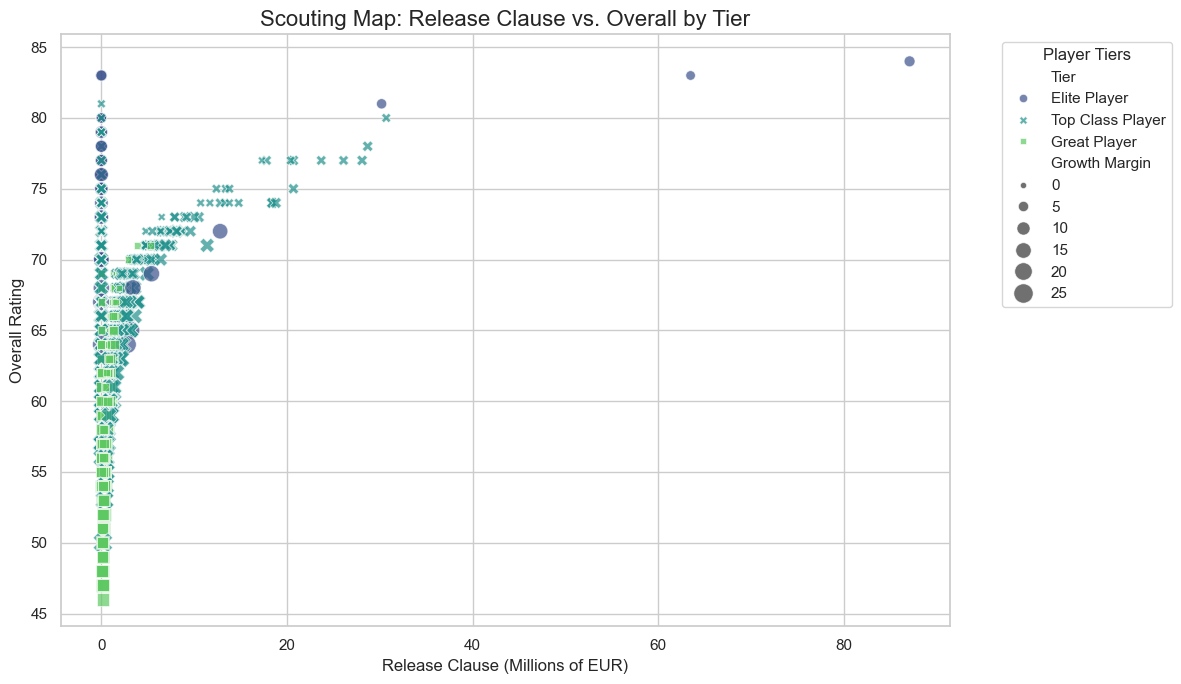

In [8]:
# Set the visual style
sns.set_theme(style="whitegrid")

# Create the Scatter Plot
plt.figure(figsize=(12, 7))
scatter = sns.scatterplot(
    data=scouting_pool,
    x='Release Clause (M_EUR)', 
    y='Overall',
    hue='Tier',
    style='Tier',
    size='Growth Margin',
    sizes=(20, 200),
    palette='viridis',
    alpha=0.7
)

# Adding titles and labels in English
plt.title('Scouting Map: Release Clause vs. Overall by Tier', fontsize=16)
plt.xlabel('Release Clause (Millions of EUR)', fontsize=12)
plt.ylabel('Overall Rating', fontsize=12)
plt.legend(title='Player Tiers', bbox_to_anchor=(1.05, 1), loc='upper left')

# Customizing the axes to better visualize the "Value" zone
plt.tight_layout()
plt.show()

The previous graphic has problems showing the vast majority of players due to two outlier players with high Release Clause. In order to improve the visualization, we will ignore these players, as they are financially impossible to sign.

This strategic map plots players based on their current quality (Overall) against their market cost. By limiting the financial scale to €40M, we focus on the high-value acquisition zone. The size of each bubble represents the 'Growth Margin', identifying 'diamonds in the rough'—players with significant room to reach their potential ceiling. Selective labeling highlights the top-ranked value opportunity in each tier for immediate identification.

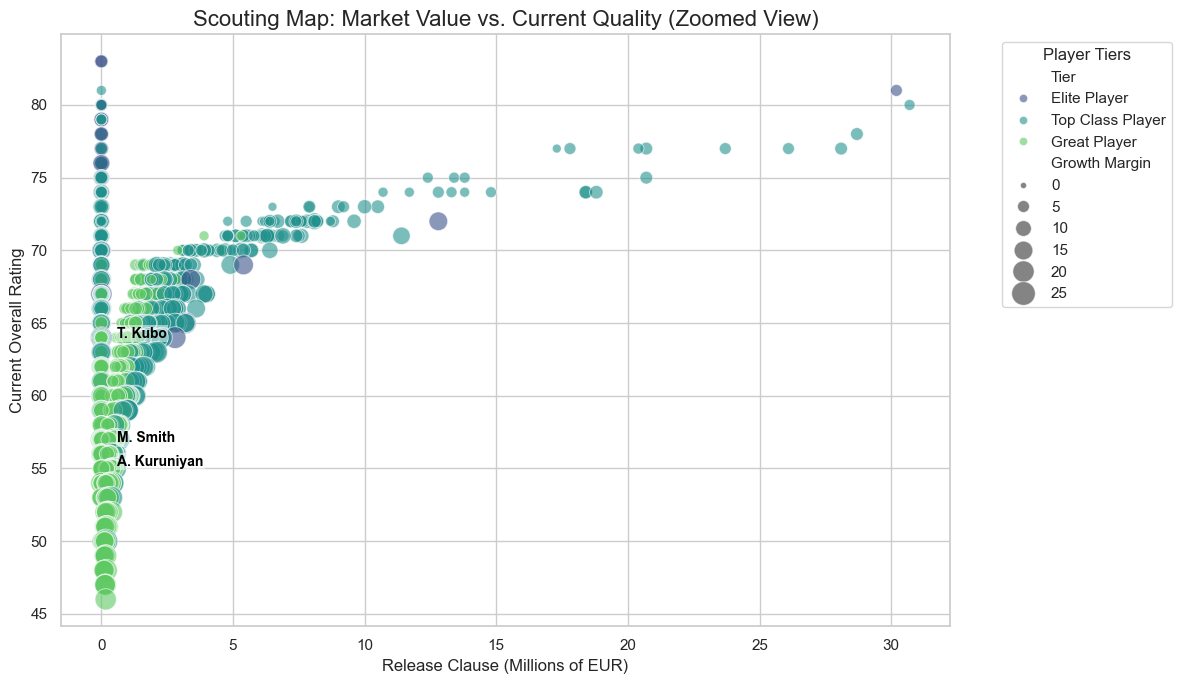

In [9]:
# Create the Improved Scatter Plot
plt.figure(figsize=(12, 7))

# 1. Limit X-axis to 40M to see the "bargain zone" clearly
scatter = sns.scatterplot(
    data=scouting_pool[scouting_pool['Release Clause (M_EUR)'] < 40], 
    x='Release Clause (M_EUR)', 
    y='Overall',
    hue='Tier',
    size='Growth Margin',
    sizes=(20, 300),
    palette='viridis',
    alpha=0.6
)

# 2. Strategic Annotations with offset to avoid overlapping
# We manually define different offsets if they are too close
top_per_tier = scouting_results[scouting_results['Tier_Rank'] == 1]

for i, row in top_per_tier.iterrows():
    if row['Release Clause (M_EUR)'] < 40:
        # Custom offsets to prevent overlap in the "bargain cluster"
        x_offset = 0.6
        y_offset = 0
        
        if row['Tier'] == 'Top Class Player': y_offset = 0.8  # Move up
        if row['Tier'] == 'Great Player': y_offset = -0.8    # Move down
            
        plt.text(row['Release Clause (M_EUR)'] + x_offset, 
                 row['Overall'] + y_offset, 
                 row['Name'], 
                 fontsize=10, weight='bold', color='black',
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=1))

plt.title('Scouting Map: Market Value vs. Current Quality (Zoomed View)', fontsize=16)
plt.xlabel('Release Clause (Millions of EUR)', fontsize=12)
plt.ylabel('Current Overall Rating', fontsize=12)
plt.legend(title='Player Tiers', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Saving figure
plt.savefig('../outputs/figures/Scouting - Global Market Overview - Cost vs Potential.png', dpi=300)

plt.show()

The visualization confirms a high concentration of value in the sub-€5M range. By adjusting the labels, we clearly identify T. Kubo, A. Kuruniyan, and M. Smith as the prime targets in their respective tiers. The vertical spread shows that even at low costs, there is a wide variety of current 'Overall' ratings available, allowing the club to choose between 'plug-and-play' talent or long-term development projects.

### Top 5 Investment Opportunities per Tier

The following chart presents the top 5 high-efficiency targets per tier, now organized by competitive hierarchy. This ranking uses our 'Final Scouting Score', which integrates financial feasibility with sporting potential. By prioritizing the 'Elite' tier at the top, we provide a clearer roadmap for clubs aiming for top-level competition versus those looking for sustainable growth in lower tiers.

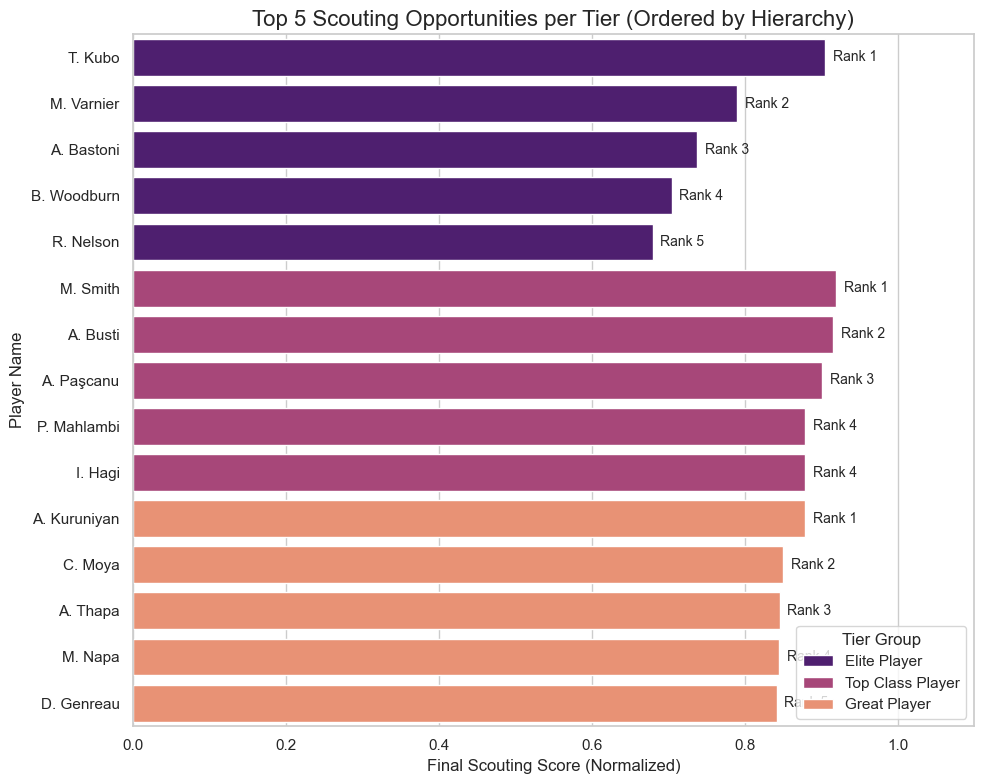

In [10]:
# 1. Define the correct logical order for Tiers
tier_order = ['Elite Player', 'Top Class Player', 'Great Player']
top_5_plot = top_deals.copy()

# 2. Transform Tier into a Categorical type with the specified order
top_5_plot['Tier'] = pd.Categorical(top_5_plot['Tier'], categories=tier_order, ordered=True)

# 3. Sort values correctly: Tier first (Elite -> Great), then Score (High -> Low)
top_5_plot = top_5_plot.sort_values(['Tier', 'Final_Scouting_Score'], ascending=[True, False])

plt.figure(figsize=(10, 8))
bar_plot = sns.barplot(
    data=top_5_plot,
    x='Final_Scouting_Score',
    y='Name',
    hue='Tier',
    palette='magma',
    dodge=False,
    hue_order=tier_order # Reinforce order in the legend
)

plt.title('Top 5 Scouting Opportunities per Tier (Ordered by Hierarchy)', fontsize=16)
plt.xlabel('Final Scouting Score (Normalized)', fontsize=12)
plt.ylabel('Player Name', fontsize=12)
plt.xlim(0, 1.1)

# Annotations (Fixed indexing for sorted dataframe)
for i, p in enumerate(bar_plot.patches):
    width = p.get_width()
    if width > 0:
        plt.text(width + 0.01, p.get_y() + p.get_height()/2, 
                 f"Rank {int(top_5_plot.iloc[i]['Tier_Rank'])}", 
                 va='center', fontsize=10)

plt.legend(title='Tier Group', loc='lower right')
plt.tight_layout()

# Saving figure
plt.savefig('../outputs/figures/Scouting - Top 5 Investment Opportunities per Tier.png', dpi=300)

plt.show()

The ranking identifies T. Kubo and M. Smith as the highest-priority targets in their respective tiers. Their dominance in the Final Score suggests a perfect storm of low cost and high ceiling. For a club with immediate needs, these players represent the highest probability of financial and sporting ROI, especially considering their favorable contract situations.

### Geographical Scouting: Nationality Distribution of Top Opportunities

To provide a comprehensive geographical roadmap for our scouting operations, this analysis uses a stratified sampling approach. We have included 100% of the 'Elite Players' identified in our dataset, alongside the top 300 most efficient 'Top Class' and 'Great' prospects. This methodology ensures that our view of the global market is not biased solely toward low-cost 'bargains' but also encompasses the highest quality tier available. By mapping these prospects by Nationality and Tier, we can identify which regions are true 'Elite' hubs and which offer the highest volume of value-for-money talent, allowing for a more balanced scouting infrastructure.

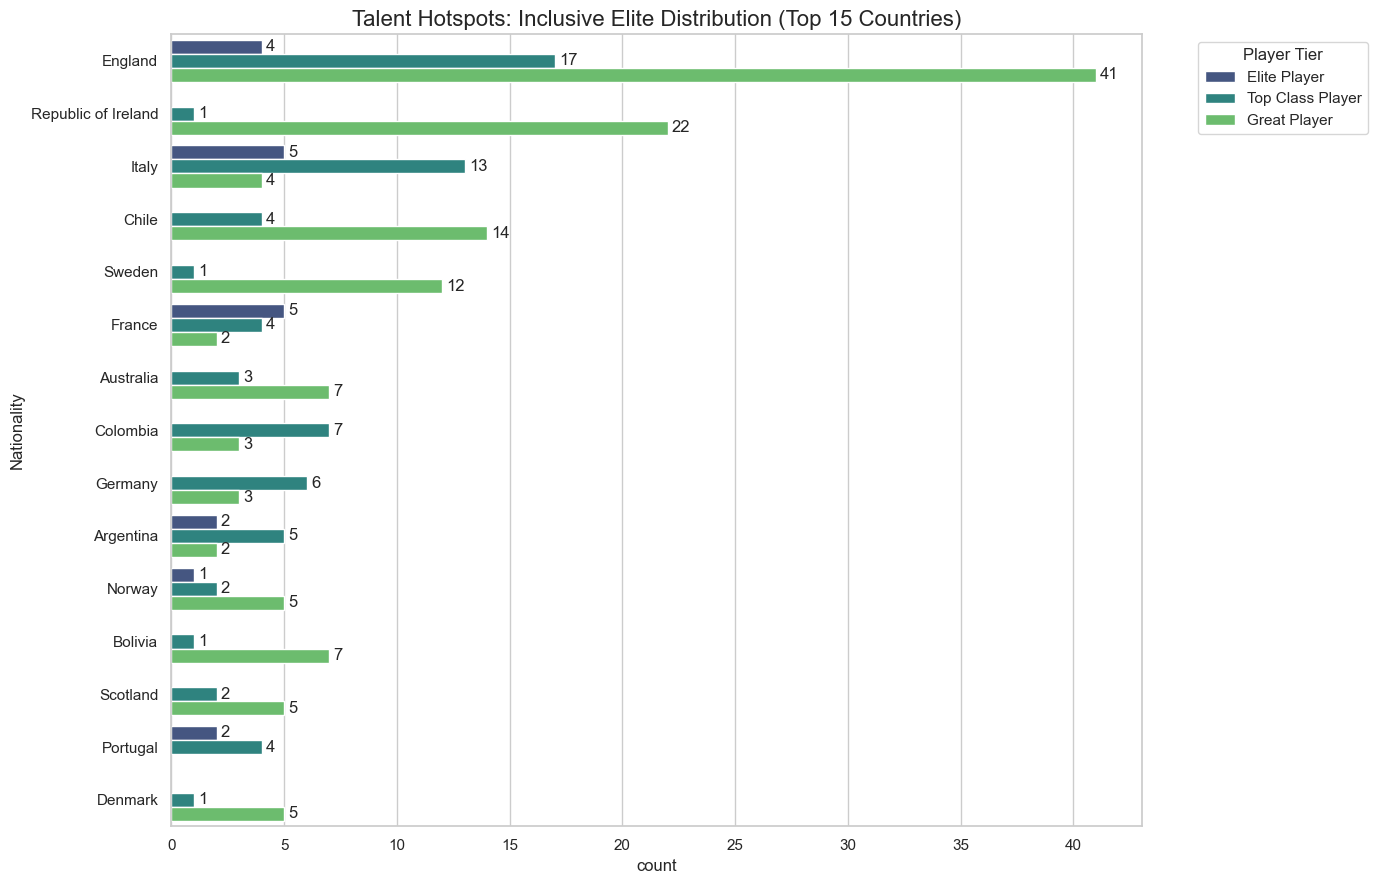

In [11]:
# 1. "Forzamos" la inclusión de todos los Elite Players
elite_all = scouting_results[scouting_results['Tier'] == 'Elite Player']

# 2. Tomamos una muestra representativa de los demás (ej: los mejores 300 que no sean Elite)
others_top = scouting_results[scouting_results['Tier'] != 'Elite Player'].nsmallest(300, 'Global_Rank')

# 3. Combinamos ambos en un nuevo dataset para el gráfico
stratified_sample = pd.concat([elite_all, others_top])

# 4. Filtramos las 15 nacionalidades más frecuentes de este nuevo grupo
top_15_nations = stratified_sample['Nationality'].value_counts().nlargest(15).index
df_plot = stratified_sample[stratified_sample['Nationality'].isin(top_15_nations)]

# 5. Visualización
plt.figure(figsize=(14, 9))
ax = sns.countplot(
    data=df_plot,
    y='Nationality',
    hue='Tier',
    order=top_15_nations,
    palette='viridis',
    hue_order=['Elite Player', 'Top Class Player', 'Great Player']
)

# Add counts
for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.title('Talent Hotspots: Inclusive Elite Distribution (Top 15 Countries)', fontsize=16)
plt.legend(title='Player Tier', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Saving figure
plt.savefig('../outputs/figures/Scouting - Nationality Distribution (Top 300).png', dpi=300)

plt.show()

The geographical distribution confirms that while England is the primary market for sheer volume (dominating in the 'Great Player' category), the true 'Elite' hotspots are found elsewhere. Italy and France emerge as the most vital markets for top-tier talent, with each producing 5 Elite prospects within this high-efficiency sample.

A critical finding is the persistent absence of traditional powerhouses like Spain from the top 15. This confirms a significant market anomaly: the 'Spanish Inflation'. Due to mandatory and often exorbitant release clauses, Spanish prospects—even those of Elite potential—frequently fail to meet our efficiency criteria for 'low-cost investments.' For a strategic scout, this suggests that while the quality in Spain is undeniable, the most accessible and profitable Elite talent is currently located in the Italian and French markets, where the balance between world-class potential and acquisition cost is far more favorable.

## 📋 Executive Scouting Summary & Action Plan

### 1. Methodology Overview
This analysis processed a global database of over 18,000 players to identify high-yield investment opportunities. By applying a **multi-dimensional scoring system**, we filtered the talent pool based on four critical pillars:
* **Value Efficiency:** Identifying high potential at a low market cost.
* **Wage-to-Performance:** Optimizing the salary-to-output ratio.
* **Growth Margin:** Prioritizing young players with the highest development ceiling.
* **Negotiation Urgency:** Leveraging favorable contract situations (expiring within 24 months).

### 2. Strategic Insights
* **The "Value Zone":** The most efficient market segment is found in players with a Release Clause below **€10M**. In this range, the correlation between price and future quality is weakest, offering the highest ROI.
* **Market Anomalies:** Countries like **Spain and Germany** act as "Premium Markets" where mandatory high release clauses penalize players in efficiency rankings. Conversely, **Italy and France** are currently the top exporters of accessible 'Elite' talent.
* **Volume vs. Quality:** While **England** leads the market in sheer volume of professional prospects, the density of **Elite-tier talent** is significantly higher in Southern European and specific South American markets.

### 3. Top Investment Recommendations
Based on the **Final Scouting Score**, the following targets should be prioritized for immediate recruitment:
1.  **Elite Target:** **T. Kubo** — Represents the most statistically sound 'Elite' investment globally.
2.  **Strategic Asset:** **A. Bastoni** — High-caliber defensive prospect with an optimized market valuation.
3.  **High-Efficiency Gem:** **A. Kuruniyan** — Leader of the 'Top Class' tier with exceptional value-for-money metrics.

### 4. Recommended Action Plan
* **Immediate Action:** Initiate contact with the Top 5 ranked players in the **Elite and Top Class** tiers before their market value escalates due to professional growth.
* **Resource Allocation:** Direct physical scouting missions to **Italy and France** to monitor the high-density elite clusters identified.
* **Financial Strategy:** Focus acquisition budgets on undervalued release clauses (under €15M) to maximize the probability of future capital gains.

# Talent Factories vs. Retirement Homes

This analysis evaluates clubs based on their squad's maturity and future potential. By comparing the average 'Overall' rating (current competitive strength) with the average 'Potential' (future ceiling), we can categorize clubs into strategic profiles. This analysis calculates the average 'Overall' and 'Potential' ratings for every professional club, regardless of whether their players are currently in our scouting 'buy list'. The resulting map categorizes clubs by their squad maturity and long-term vision: identifying established powerhouses with high current quality, 'Academy Hubs' (Talent Factories) focused on development, and aging squads (Retirement Homes) in need of immediate structural change.

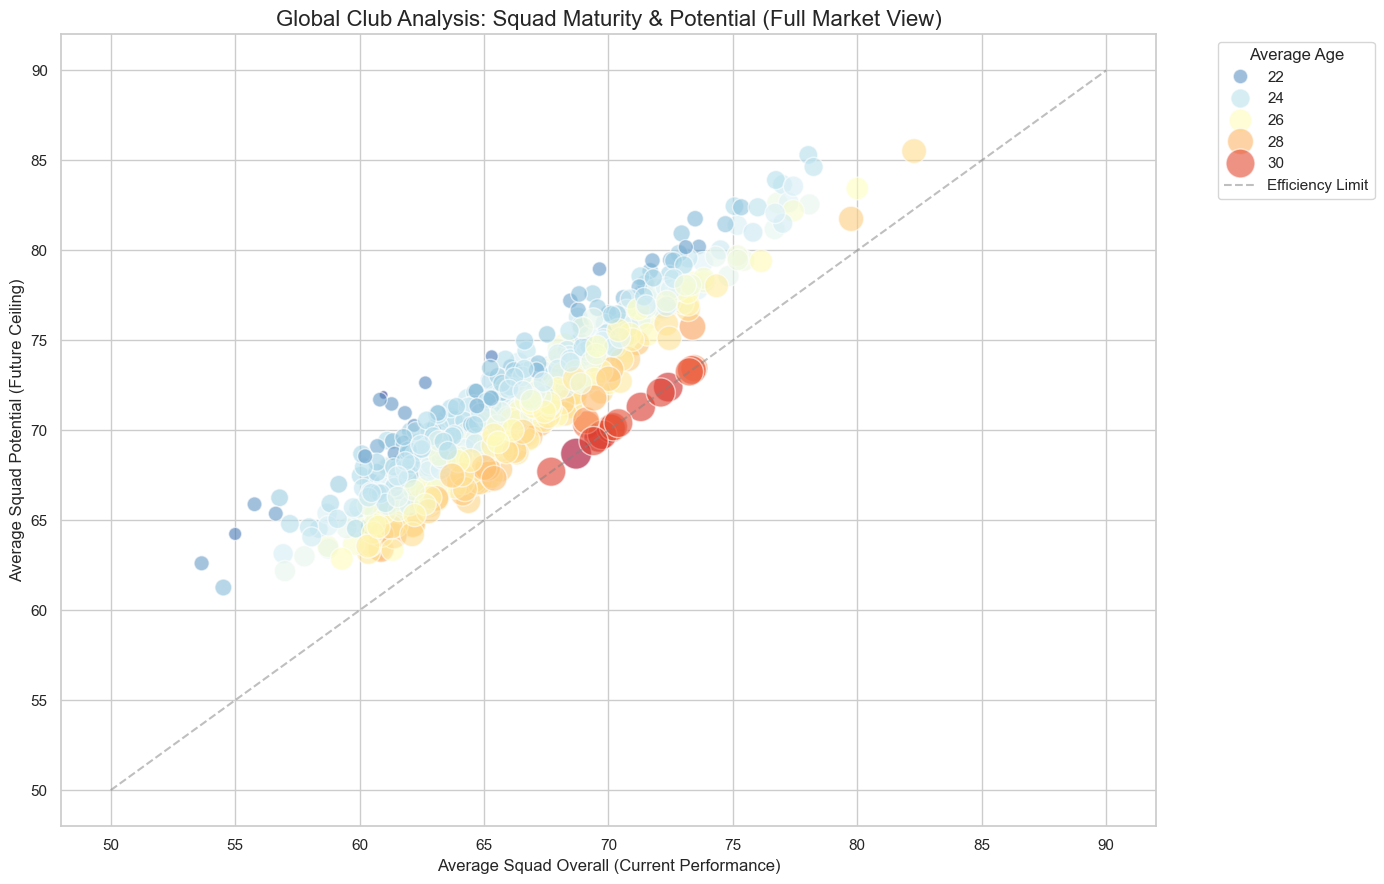

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Use the full cleaned dataset (e.g., df_cleaned) instead of the scouting pool
# Grouping all 18,000+ players by Club
club_full_stats = data.groupby('Club').agg({
    'Overall': 'mean',
    'Potential': 'mean',
    'Age': 'mean'
}).reset_index()

# 2. Filter for clubs with a significant squad size (at least 15 players) 
# to ensure the averages are representative of a real squad
full_club_counts = data['Club'].value_counts()
relevant_full_clubs = full_club_counts[full_club_counts >= 15].index
club_full_stats = club_full_stats[club_full_stats['Club'].isin(relevant_full_clubs)]

# 3. Visualization
plt.figure(figsize=(14, 9))
scatter = sns.scatterplot(
    data=club_full_stats,
    x='Overall',
    y='Potential',
    size='Age',
    hue='Age',
    sizes=(40, 500),
    palette='RdYlBu_r', # Red for older, Blue for younger squads
    alpha=0.6
)

# Reference line: Where Potential equals Overall (Zero growth margin)
plt.plot([50, 90], [50, 90], ls='--', color='gray', alpha=0.5, label='Efficiency Limit')

plt.title('Global Club Analysis: Squad Maturity & Potential (Full Market View)', fontsize=16)
plt.xlabel('Average Squad Overall (Current Performance)', fontsize=12)
plt.ylabel('Average Squad Potential (Future Ceiling)', fontsize=12)
plt.legend(title='Average Age', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Saving figure
plt.savefig('../outputs/figures/Club Analysis - Squad Maturity & Potential (Top 300).png', dpi=300)

plt.show()

The global market view reveals a strong linear relationship between current performance and future ceiling. However, the vertical distance from the Efficiency Limit (dashed line) acts as a critical indicator of a club's long-term sustainability.

* Talent Factories (Blue Clusters): Clubs positioned significantly above the efficiency line with smaller, blue-toned bubbles represent the healthiest strategic models. These squads maintain high competitive levels while nurturing a vast growth margin, primarily driven by their lower average age (22–24 years).

* Established Powerhouses: The top-right quadrant identifies elite clubs that balance high current ratings (Overall > 75) with high potential, often maintaining a slightly more mature but still developing squad.

* Aging Squads at Risk (Red Clusters): Bubbles that sit directly on or near the efficiency line—particularly the larger, red-toned ones (Age 30+)—identify clubs with stagnant growth. These squads are at their peak performance but face an imminent competitive decline, signaling a high priority for the scouting-led rejuvenation strategies identified in earlier stages of this project.

To transform macro trends into actionable intelligence, we segment the market into two critical club profiles. First, we identify the 'Talent Factories': institutions whose management model focuses on accumulating players with the highest developmental ceiling. These clubs are the primary sources for future elite talent. Second, we pinpoint the 'Aging Squads': clubs with solid immediate performance (Overall > 70) but near-zero growth margins and high average ages. These organizations represent the primary demand side of the market, as they face an imminent competitive decline and an urgent need for the scouting-led rejuvenation strategies identified in this project.

In [13]:
# Preparing metrics for the analysis
club_analysis = data.groupby('Club').agg({
    'Overall': 'mean',
    'Potential': 'mean',
    'Age': 'mean',
    'Name': 'count'
}).rename(columns={'Name': 'Squad_Size'})

# Calculating mean growth margin
club_analysis['Avg_Growth_Margin'] = club_analysis['Potential'] - club_analysis['Overall']

# Filtering clubs with realistic squads (más de 15 jugadores)
club_analysis = club_analysis[club_analysis['Squad_Size'] >= 15]

# --- ANALYSIS 1: TOP 10 TALENT FACTORIES ---
# (Top growth margin & low age)
talent_factories = club_analysis.sort_values(by='Avg_Growth_Margin', ascending=False).head(10)
# Saving the report
talent_factories.to_csv('../outputs/reports/talent_factories.csv')

# --- ANALYSIS 2: TOP 10 AGING SQUADS AT RISK ---
# (High Overall, but growth margin near 0 and high age)
aging_squads = club_analysis[club_analysis['Overall'] > 70].sort_values(by=['Avg_Growth_Margin', 'Age'], ascending=[True, False]).head(10)
# Saving the report
talent_factories.to_csv('../outputs/reports/aging squads.csv')

print("Top 10 Talent Factories (Highest Growth Margin):")
display(talent_factories[['Squad_Size', 'Overall', 'Potential', 'Avg_Growth_Margin', 'Age']])

print("\nTop 10 Aging Squads (Highest Need for Renovation):")
display(aging_squads[['Squad_Size', 'Overall', 'Potential', 'Avg_Growth_Margin', 'Age']])

Top 10 Talent Factories (Highest Growth Margin):


,Squad_Size,Overall,Potential,Avg_Growth_Margin,Age
Club,,,,,
FC Nordsjælland,27,60.962963,71.962963,11.000000,20.259259
Stabæk Fotball,27,60.814815,71.703704,10.888889,22.074074
Envigado FC,28,61.285714,71.464286,10.178571,22.035714
Derry City,18,55.777778,65.888889,10.111111,22.111111
FC Sochaux-Montbéliard,28,62.642857,72.642857,10.000000,21.678571
Crewe Alexandra,28,56.785714,66.250000,9.464286,23.357143
LOSC Lille,25,69.640000,78.960000,9.320000,22.000000
Bohemian FC,25,55.000000,64.240000,9.240000,21.480000
Barnsley,28,61.821429,70.964286,9.142857,22.107143



Top 10 Aging Squads (Highest Need for Renovation):


,Squad_Size,Overall,Potential,Avg_Growth_Margin,Age
Club,,,,,
Cruzeiro,20,72.40,72.40,0.0,30.6
Botafogo,20,71.30,71.30,0.0,30.4
Fluminense,20,72.10,72.10,0.0,30.2
Bahia,20,70.10,70.10,0.0,30.0
Grêmio,20,73.35,73.35,0.0,30.0
Vitória,20,70.40,70.40,0.0,30.0
Internacional,20,73.25,73.25,0.0,29.6
Santos,20,70.20,70.20,0.0,29.6
Atlético Mineiro,20,73.45,73.45,0.0,28.8


The data reveals a stark contrast in sporting models across different regions. The Talent Factories list is led by FC Nordsjælland with an extraordinary average growth margin of +11.00 and a squad average age of just 20.2 years, showcasing a pure developmental philosophy. In contrast, the Aging Squads list is almost exclusively populated by Brazilian clubs such as Cruzeiro, Botafogo, and Fluminense, all maintaining average ages above 30 and growth margins near 0.0.

For a strategic consultancy, this identifies a clear 'Trade Lane': the talent developed in the upper-quadrant factories is the exact solution required by the stagnant squads in the lower-quadrant. This structural gap in the market confirms that our scouting tools are not just useful for finding players, but for identifying the specific clubs that will be forced to participate in the transfer market to survive competitively.

# Positional Scarcity & Market Inflation Analysis

To conclude our strategic assessment, we shift our focus to the economic structure of the football market. Recruitment is not only about finding talent but also about understanding where capital is most efficiently deployed. This analysis explores Positional Inflation: the phenomenon where certain areas of the pitch command a premium price regardless of player quality. By utilizing our club_filtering utility, we segment the global market into competitive tiers (Elite, Top-Tier, and Mid-Market). This allows us to identify 'Scarcity Zones'—positions where talent is exceptionally expensive—and 'Value Pockets'—positions where high-quality reinforcements can be acquired at a fraction of the cost. Understanding these dynamics is the final step in building a sustainable and financially responsible recruitment strategy.

### 1. Tier definition

We will use our club_filtering function to segment the market into three competitiveness tiers. This segmentation is key to our analysis, as inflation does not affect the same way to mid-table clubs than those clubs fighting for the Champions League:

* Elite/Top Clubs: min=75, max=100 (premium market).

* Medium/High Clubs: min=65, max=75 (mid competitiveness class).

* Low/Development Clubs: min=0, max=65 (Formation markets or minor leagues).

In [17]:
# 1. Tier segmentation using club_filtering function
df_elite  = club_filtering(data, min=75, max=100).copy()
df_medium = club_filtering(data, min=65, max=75).copy()
df_low    = club_filtering(data, min=0,  max=65).copy()

# 2. Adding a tier tag to each df to join and graphic them
df_elite.loc[:, 'Market_Tier'] = 'Elite (75+)'
df_medium.loc[:, 'Market_Tier'] = 'Mid-High (65-75)'
df_low.loc[:, 'Market_Tier'] = 'Development (<65)'

# 3. Joining for comparative visualization
df_market_analysis = pd.concat([df_elite, df_medium, df_low])

# Showing player volume from each tear to validate the segmentation
print("Player distribution by Tier market:")
print(df_market_analysis['Market_Tier'].value_counts())

Player distribution by Tier market:
Market_Tier
Mid-High (65-75)     10049
Development (<65)     7381
Elite (75+)            717
Name: count, dtype: int64


In [19]:
df_market_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18147 entries, 0 to 18146
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Name                        18147 non-null  object        
 1   Age                         18147 non-null  int64         
 2   Nationality                 18147 non-null  object        
 3   Overall                     18147 non-null  int64         
 4   Potential                   18147 non-null  int64         
 5   International Reputation    18147 non-null  int64         
 6   Club                        18147 non-null  object        
 7   Wage (K_EUR)                18147 non-null  float64       
 8   Preferred Foot              18147 non-null  object        
 9   Weak Foot                   18147 non-null  int64         
 10  Position                    18147 non-null  object        
 11  Position_Group              18147 non-null  object        


We can see that the majority of players fall into the Mid-High Tier, followed by Development Tier, and only a few belong to the Elite Tier.

### 2. Economic metrics aggregation by position

For each Tier created, we will calculate, grouping by position (GK, DEF, MDF, ATT):

* The mean Release Clause, Wage and Overall.

* Acquisition Cost per Point:  to help identifying transfer inflation. It will allow us to check, for example, if an attacker with 80 Overall in the Elite Tier has a proportionaly much higher Release Clause than a Goal Keeper with the same Overall.

* Wage Cost per Point: to help identifying maintanance inflation. Status metric. Despite a player can be a bargaint due to its Release Clause, a high Wage could make him inefficient. If Wage_Cost_Per_Point is high in attackers of Elite Tier, we will confirm that their are not only expensive to buy, but to mantain also.

In [23]:
# 1. Grouping by market tier and position group
# Calculating metrics
positional_economy = df_market_analysis.groupby(['Market_Tier', 'Position_Group']).agg({
    'Release Clause (M_EUR)': 'mean',
    'Wage (K_EUR)': 'mean',
    'Overall': 'mean'
}).reset_index()

# 2. Calculating Acquisition/Quality Ratio
# Release Clause millions euros per Overall point
positional_economy['Acquisition_Cost_per_Point'] = (
    positional_economy['Release Clause (M_EUR)'] / positional_economy['Overall']
)

# 3. Calculating Wage/Quality Ratio
# Wage thousand euros per Overall point
positional_economy['Wage_Cost_per_Point'] = (
    positional_economy['Wage (K_EUR)'] / positional_economy['Overall']
)


# 4. Define the correct logical order for Tiers
tier_order = ['Elite (75+)', 'Mid-High (65-75)', 'Development (<65)']

# 5. Transform Tier into a Categorical type with the specified order
positional_economy['Market_Tier'] = pd.Categorical(positional_economy['Market_Tier'], categories=tier_order, ordered=True)

# 6. Ordering by Tier and Release Clause to see the most expensive tiers
positional_economy = positional_economy.sort_values(
    by=['Market_Tier', 'Release Clause (M_EUR)'], 
    ascending=[True, False]
)

print("Economic metrics (Release Clause and Wage) by Position Group and Tier:")
positional_economy.to_csv('../outputs/reports/Economic metrics by Position Group and Tier.csv')
display(positional_economy)

Economic metrics (Release Clause and Wage) by Position Group and Tier:


,Market_Tier,Position_Group,Release Clause (M_EUR),Wage (K_EUR),Overall,Acquisition_Cost_per_Point,Wage_Cost_per_Point
4,Elite (75+),ATT,44.680578,92.687500,77.117188,0.579385,1.201905
7,Elite (75+),MDF,34.900147,70.352518,77.381295,0.451015,0.909167
5,Elite (75+),DEF,26.442009,65.434211,77.188596,0.342564,0.847719
6,Elite (75+),GK,21.701422,48.445783,74.445783,0.291506,0.650753
11,Mid-High (65-75),MDF,5.372088,11.298059,68.833555,0.078045,0.164136
8,Mid-High (65-75),ATT,5.215702,12.611790,68.630377,0.075997,0.183764
9,Mid-High (65-75),DEF,3.947448,10.130012,68.578676,0.057561,0.147714
10,Mid-High (65-75),GK,3.144200,7.389937,67.009883,0.046921,0.110281
0,Development (<65),ATT,1.222382,3.156361,62.432836,0.019579,0.050556
3,Development (<65),MDF,1.016615,2.702751,62.395498,0.016293,0.043316


The results from our positional_economy table provide a fascinating breakdown of market dynamics, especially when looking at the Elite (75+) tier:

* The "Attacker Tax" is extreme at the top: In the Elite segment, an ATT costs nearly double (0.58M) per Overall point compared to a GK (0.29M). This confirms that as clubs move into the top-tier competitive bracket, the price of offensive talent scales exponentially compared to defensive roles.

* Wage vs. Acquisition: Notice that while MDF and ATT have relatively similar acquisition costs per point in the Mid-High tier, the Wage_Cost_per_Point for attackers starts to pull away significantly in the Elite tier (1.20 for ATT vs 0.90 for MDF). This suggests that elite attackers demand a "superstar premium" in their salary that exceeds even their high transfer valuations.

* Market Flattening in lower tiers: In the Development (<65) tier, the cost differences between positions are marginal. Inflation is a "luxury problem"—it only becomes a significant strategic hurdle once you are scouting for clubs with an average Overall above 70-75.

### 3. Identifying the Attacking Premium (Gap Analysis)

To finalize the analytical phase before moving to the chart, we will calculate the Attacker Premium. This metric quantifies exactly how much more expensive it is to acquire an attacker compared to a defender in each market tier.

Step-by-Step Approach:

* Pivot the Data: We will reshape the positional_economy table so that each Market_Tier has columns for different Position_Group costs.

* Calculate the Percentage Gap: We will create a formula to see the percentage increase in Acquisition_Cost_per_Point of ATT relative to DEF.

* Calculate the Wage Gap: We will do the same for Wage_Cost_per_Point to see if the "salary inflation" follows the same pattern as the "transfer inflation."

In [25]:
# 1. Pivoting the table to compare positions side-by-side per Tier
gap_analysis = positional_economy.pivot(
    index='Market_Tier', 
    columns='Position_Group', 
    values=['Acquisition_Cost_per_Point', 'Wage_Cost_per_Point']
)

# 2. Calculating the % Premium of Attackers (ATT) vs Defenders (DEF)
# Formula: ((ATT / DEF) - 1) * 100
gap_analysis['Attacker_Acquisition_Premium_%'] = (
    (gap_analysis[('Acquisition_Cost_per_Point', 'ATT')] / 
     gap_analysis[('Acquisition_Cost_per_Point', 'DEF')]) - 1
) * 100

gap_analysis['Attacker_Wage_Premium_%'] = (
    (gap_analysis[('Wage_Cost_per_Point', 'ATT')] / 
     gap_analysis[('Wage_Cost_per_Point', 'DEF')]) - 1
) * 100

# 3. Displaying the results focusing on the gaps
gap_analysis.to_csv('../outputs/reports/Economic gap analysis.csv')
print("Attacker Premium Analysis (Percentage Gap vs Defenders):")
display(gap_analysis[['Attacker_Acquisition_Premium_%', 'Attacker_Wage_Premium_%']].round(2))

Attacker Premium Analysis (Percentage Gap vs Defenders):


,Attacker_Acquisition_Premium_%,Attacker_Wage_Premium_%
Position_Group,,
Market_Tier,,
Elite (75+),69.13,41.78
Mid-High (65-75),32.03,24.41
Development (<65),81.37,37.23


The results from the Attacker Premium analysis are striking and provide the perfect economic closure to our study. Looking at the data, we can draw a definitive conclusion about how the market "taxes" goal-scoring talent across different levels.

**Conclusion**: The Scalability of Positional Inflation

The data confirms that market inflation is not linear; it is highly sensitive to the competitive tier of the club.

* The Elite Premium: In the Elite (75+) tier, acquiring an attacker costs 69.13% more per quality point (Overall) than a defender. This represents a massive 'transfer tax' for top-level clubs. Interestingly, the wage premium is lower (41.78%), suggesting that while elite strikers are expensive to buy, their salary demands—though high—are slightly more aligned with other elite positions compared to their astronomical release clauses.

* The Development Paradox: We see the highest acquisition premium (81.37%) in the Development (<65) tier. This suggests a 'scarcity of proven potential.' In lower leagues, players who show any attacking efficiency are priced disproportionately high because they represent the quickest ticket to promotion or a high-value sale to a bigger club.

* Mid-Market Efficiency: The Mid-High (65-75) tier appears to be the most 'rational' market. With an acquisition premium of only 32.03%, this tier offers the best balance for clubs looking to reinforce their attack without facing the extreme inflation found at the very top or the speculative pricing found at the bottom.

### 4. Comparative visualization



### Absolute Market Heat: Average Release Clause by Tier & Position

This first visualization maps the absolute costs across market tiers. It highlights where the largest financial investments are concentrated and confirms the exponential price jump as we move from development leagues to the elite footballing world. It serves as a 'Heat Map' for where the most capital is required to compete.

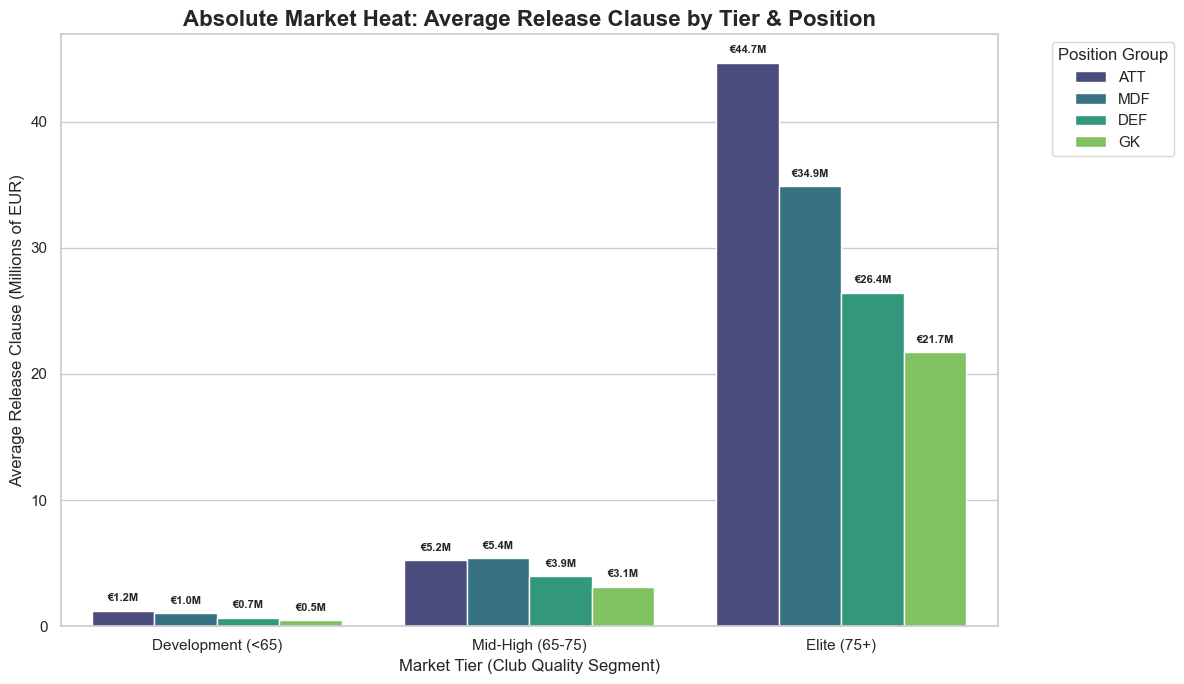

In [26]:
# Setting the visual style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

# Creating the bar plot for absolute acquisition costs
ax1 = sns.barplot(
    data=positional_economy,
    x='Market_Tier',
    y='Release Clause (M_EUR)',
    hue='Position_Group',
    palette='viridis',
    order=['Development (<65)', 'Mid-High (65-75)', 'Elite (75+)']
)

plt.title('Absolute Market Heat: Average Release Clause by Tier & Position', fontsize=16, fontweight='bold')
plt.xlabel('Market Tier (Club Quality Segment)', fontsize=12)
plt.ylabel('Average Release Clause (Millions of EUR)', fontsize=12)
plt.legend(title='Position Group', bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotating bars with values
for p in ax1.patches:
    if p.get_height() > 0:
        ax1.annotate(f'€{p.get_height():.1f}M', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/MarketPos_market_heat_release_clause.png')

plt.show()

The absolute market value distribution confirms a massive financial 'jump' between tiers. In the Elite (75+) segment, attackers (ATT) command an average release clause of €44.7M, which is more than 8.5 times the cost of an attacker in the Mid-High (65-75) tier (€5.2M). This visualization highlights that while the Mid-High market is relatively accessible, competing for elite talent requires an exponential increase in capital, with attackers and midfielders (MDF) significantly outpricing defensive roles across all competitive levels.

### The Efficiency Map: Acquisition Cost per Overall Point

Beyond absolute prices, we need to understand value. This chart displays the 'Acquisition Cost per Overall Point', revealing how much a club pays for each unit of performance. This is the definitive tool for identifying 'Positional Inflation'—showing exactly where the market is overpaying for quality and where the most efficient impact signings are hidden.

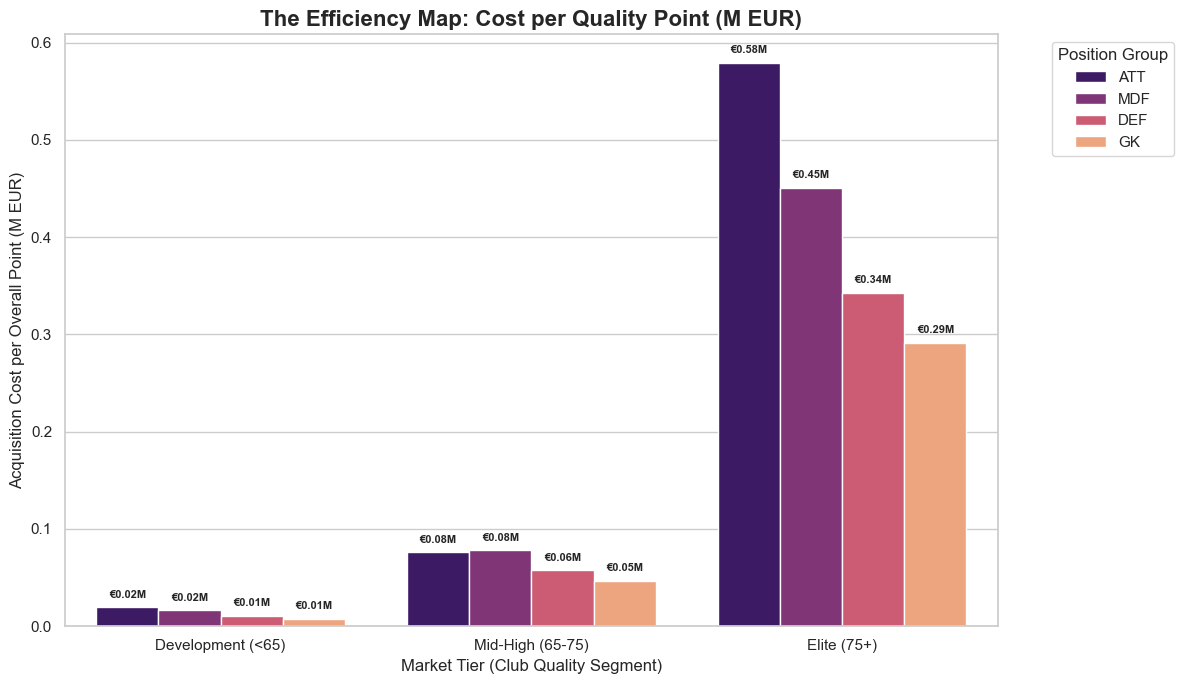

In [27]:
plt.figure(figsize=(12, 7))

# Creating the bar plot for value-for-money
ax2 = sns.barplot(
    data=positional_economy,
    x='Market_Tier',
    y='Acquisition_Cost_per_Point',
    hue='Position_Group',
    palette='magma',
    order=['Development (<65)', 'Mid-High (65-75)', 'Elite (75+)']
)

plt.title('The Efficiency Map: Cost per Quality Point (M EUR)', fontsize=16, fontweight='bold')
plt.xlabel('Market Tier (Club Quality Segment)', fontsize=12)
plt.ylabel('Acquisition Cost per Overall Point (M EUR)', fontsize=12)
plt.legend(title='Position Group', bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotating bars with values
for p in ax2.patches:
    if p.get_height() > 0:
        ax2.annotate(f'€{p.get_height():.2f}M', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/MarketPos_efficiency_map_cost_per_point.png')

plt.show()

This chart reveals the true 'Positional Inflation' by neutralizing the player's quality (Overall). It illustrates that in the Elite tier, a club pays €0.58M per point of Overall for an attacker, nearly double what they pay for a goalkeeper (€0.29M). Interestingly, the Development (<65) tier shows a significant efficiency gap where attackers (€0.02M/point) are twice as expensive as defenders (€0.01M/point), suggesting that even at low competitive levels, the market aggressively overprices goal-scoring potential relative to defensive stability.

### The Status Premium: Wage Distribution per Overall Point

Finally, we analyze the 'Wage Cost per Overall Point'. This provides a view of the recurring financial burden (salaries) relative to player quality. It helps identify if certain positions command a higher 'Status Premium' in their weekly paychecks compared to their defensive counterparts, which is critical for long-term financial sustainability.

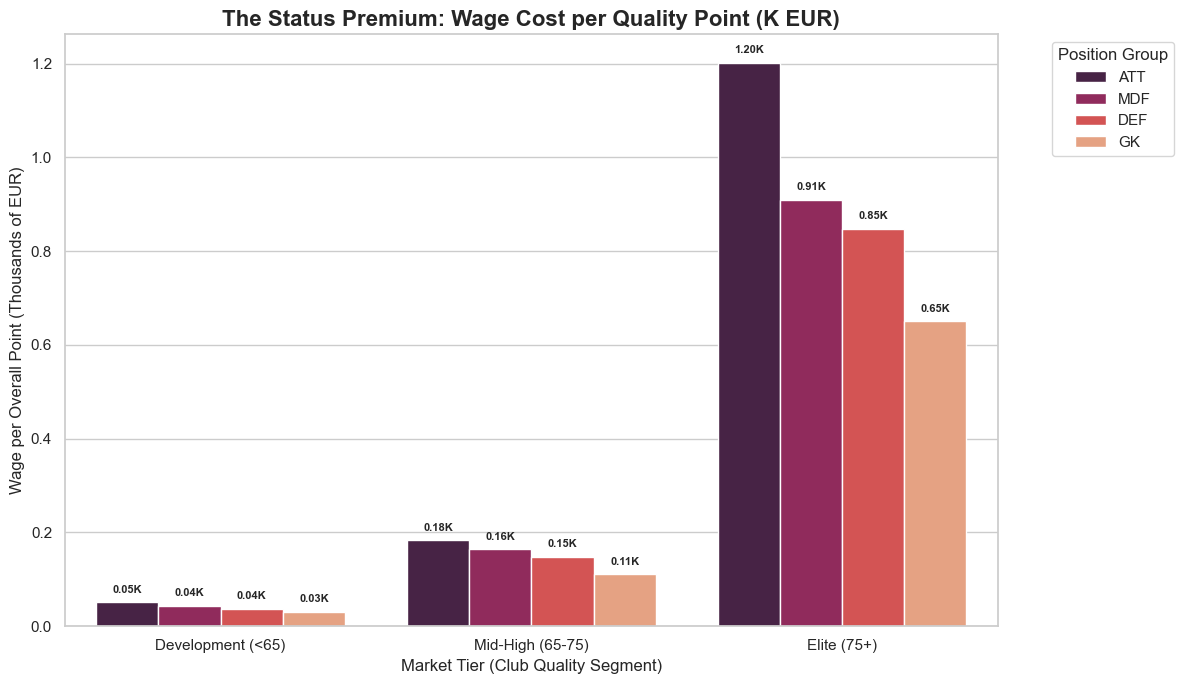

In [28]:
plt.figure(figsize=(12, 7))

# Creating the bar plot for salary efficiency
ax3 = sns.barplot(
    data=positional_economy,
    x='Market_Tier',
    y='Wage_Cost_per_Point',
    hue='Position_Group',
    palette='rocket',
    order=['Development (<65)', 'Mid-High (65-75)', 'Elite (75+)']
)

plt.title('The Status Premium: Wage Cost per Quality Point (K EUR)', fontsize=16, fontweight='bold')
plt.xlabel('Market Tier (Club Quality Segment)', fontsize=12)
plt.ylabel('Wage per Overall Point (Thousands of EUR)', fontsize=12)
plt.legend(title='Position Group', bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotating bars with values
for p in ax3.patches:
    if p.get_height() > 0:
        ax3.annotate(f'{p.get_height():.2f}K', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/MarketPos_status_premium_wage_per_point.png')

plt.show()

The wage analysis demonstrates that elite attackers do not just cost more to buy; they are significantly more expensive to maintain. In the Elite tier, attackers earn 1.20K per point of Overall, a 'Status Premium' that sits 41% higher than defenders (0.85K) and 84% higher than goalkeepers (0.65K). For a club's long-term sustainability, this chart proves that the most significant 'wage bill' risk lies in the attacking frontline, while the Mid-High tier offers a much more balanced and sustainable wage structure across all positions.

# 5. 📋 Market Inflation: Positional Value & Scarcity Analysis

## Introduction
To conclude our strategic assessment, we shift our focus to the economic structure of the football market. Recruitment is not only about finding talent but also about understanding where capital is most efficiently deployed. This analysis explores **Positional Inflation**: the phenomenon where certain areas of the pitch command a premium price regardless of player quality. By utilizing our `club_filtering` utility, we segment the global market into competitive tiers (Elite, Top-Tier, and Mid-Market). This allows us to identify 'Scarcity Zones'—positions where talent is exceptionally expensive—and 'Value Pockets'—positions where high-quality reinforcements can be acquired at a fraction of the cost. Understanding these dynamics is the final step in building a sustainable and financially responsible recruitment strategy.

---

## Executive Summary: Positional Market Dynamics

### 1. Market Segmentation & Concentration
The market is heavily top-heavy, with the **Elite (75+)** tier commanding release clauses nearly **8.5 times higher** than the Mid-High segment. While the **Development (<65)** tier serves as a high-volume talent pool, capital concentration in the Elite tier creates a high-barrier entry for clubs attempting to break into the top competitive bracket.

### 2. The "Attacker Tax" & Scarcity Premium
Our analysis confirms that goal-scoring talent is the most inflated commodity in football:
* **Acquisition Inflation:** In the Elite tier, clubs pay **€0.58M per Overall point** for attackers, a **69.13% premium** over defenders.
* **Maintenance Burden:** The "Status Premium" is evident in wages, where elite attackers earn **1.20K per point**, significantly outstripping the salary growth of goalkeepers and defenders.
* **Early Speculation:** Surprisingly, the highest acquisition premium relative to quality (**81.37%**) is found in the **Development** tier, indicating that clubs aggressively overprice young attacking prospects based on potential rather than current output.

### 3. Strategic "Value Pockets"
The **Mid-High (65-75)** tier represents the most rational and efficient segment of the market. With an attacking premium of only **32.03%**—the lowest across all tiers—this segment offers the best opportunity for clubs to upgrade their squads without facing the exponential "superstar tax" of the Elite tier or the speculative volatility of the Development tier.

### 4. Strategic Recommendations
* **For Buyer Clubs:** Focus investment on the **Mid-High** tier for attacking roles to maximize "Quality per Euro".
* **For Seller Clubs:** Target the **Elite** market when offloading attackers, as the price-to-quality ratio scales most aggressively in that segment.
* **Budget Allocation:** Prioritize high-spending for **ATT** and **MDF** roles while seeking "Efficient Stability" in **DEF** and **GK** positions, where quality can be acquired at nearly half the cost per point.

---

## Visual Data Analysis

### Absolute Market Heat: Average Release Clause by Tier & Position
"This first visualization maps the absolute costs across market tiers. It highlights where the largest financial investments are concentrated and confirms the exponential price jump as we move from development leagues to the elite footballing world. It serves as a 'Heat Map' for where the most capital is required to compete."

**Conclusion:** The absolute market value distribution confirms a massive financial 'jump' between tiers. In the **Elite (75+)** segment, attackers (ATT) command an average release clause of **€44.7M**, which is more than **8.5 times** the cost of an attacker in the **Mid-High (65-75)** tier (€5.2M). This highlights that while the Mid-High market is relatively accessible, competing for elite talent requires an exponential increase in capital.

### The Efficiency Map: Cost per Quality Point (M EUR)
"Beyond absolute prices, we need to understand value. This chart displays the 'Acquisition Cost per Overall Point', revealing how much a club pays for each unit of performance. This is the definitive tool for identifying 'Positional Inflation'—showing exactly where the market is overpaying for quality and where the most efficient impact signings are hidden."

**Conclusion:** This chart reveals the true 'Positional Inflation' by neutralizing the player's quality (Overall). It illustrates that in the **Elite** tier, a club pays **€0.58M per point of Overall** for an attacker, nearly **double** what they pay for a goalkeeper (€0.29M). Interestingly, the **Development (<65)** tier also shows a significant efficiency gap, suggesting that the market aggressively overprices goal-scoring potential even at lower levels.

### The Status Premium: Wage Cost per Quality Point (K EUR)
"Finally, we analyze the 'Wage Cost per Overall Point'. This provides a view of the recurring financial burden (salaries) relative to player quality. It helps identify if certain positions command a higher 'Status Premium' in their weekly paychecks compared to their defensive counterparts, which is critical for long-term financial sustainability."

**Conclusion:** The wage analysis demonstrates that elite attackers do not just cost more to buy; they are significantly more expensive to maintain. In the **Elite** tier, attackers earn **1.20K per point of Overall**, a 'Status Premium' that sits **41% higher** than defenders (0.85K). For a club's long-term sustainability, the most significant 'wage bill' risk lies in the attacking frontline.

# Final Curiosity: The Elite Lifecycle

As a final curiosity, we visualize the 'Competitive Lifecycle' of the game's most prestigious clubs. This analysis maps the average age of an elite squad against its collective performance level (Overall). It allows us to distinguish between 'Veteran Powerhouses'—clubs that rely on experience and immediate results—and 'Rising Dynasties'—younger squads already performing at the highest level. This snapshot provides a unique perspective on the long-term sustainability and current status of the footballing elite.

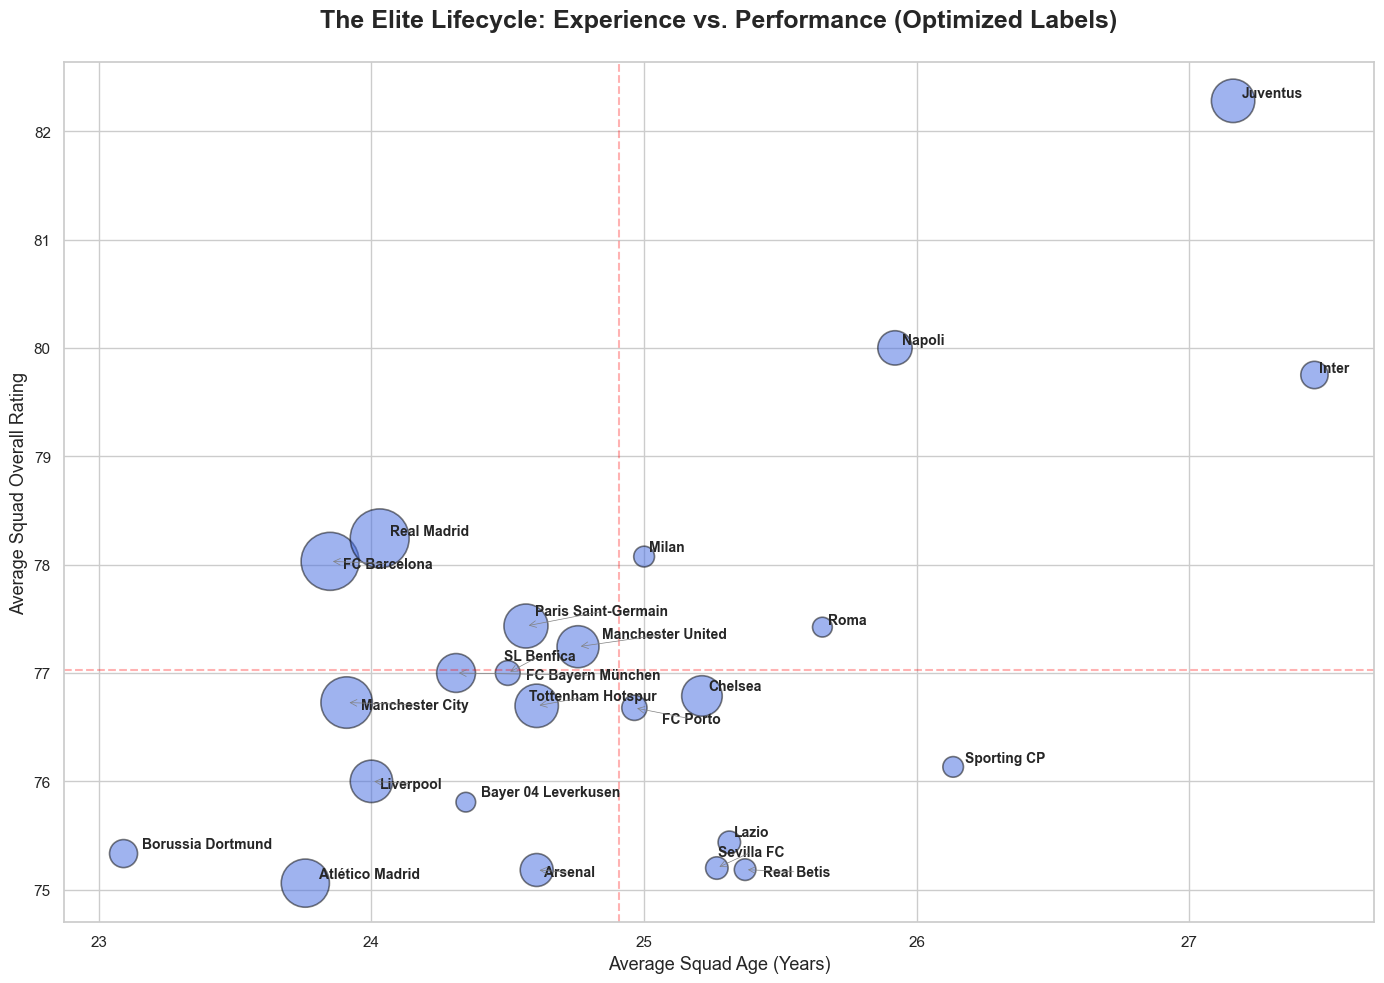

In [ ]:
from adjustText import adjust_text

# 1. Segmentation of Elite Clubs
elite_players = club_filtering(data, min=75)

# 2. Aggregating metrics
elite_status = elite_players.groupby('Club').agg({
    'Overall': 'mean',
    'Age': 'mean',
    'Release Clause (M_EUR)': 'sum'
}).reset_index()

# 3. Grapgic configuration
plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")

scatter = sns.scatterplot(
    data=elite_status,
    x='Age',
    y='Overall',
    size='Release Clause (M_EUR)',
    sizes=(200, 1800),
    alpha=0.5,
    color='royalblue',
    edgecolor='black',
    legend=False
)

# 4. Label creation
texts = []
for i in range(elite_status.shape[0]):
    texts.append(plt.text(
        elite_status.Age[i], 
        elite_status.Overall[i], 
        elite_status.Club[i], 
        fontsize=10, 
        fontweight='semibold'
    ))

# 5. Automatic label adjustment
# 'expand_points' & 'expand_text' control label separation
adjust_text(texts, 
            only_move={'points':'y', 'text':'xy'}, 
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
            expand_points=(1.5, 1.5),
            expand_text=(1.2, 1.2))

# Reference lines (mean)
plt.axvline(elite_status['Age'].mean(), color='red', linestyle='--', alpha=0.3)
plt.axhline(elite_status['Overall'].mean(), color='red', linestyle='--', alpha=0.3)

plt.title('The Elite Lifecycle: Experience vs. Performance (Optimized Labels)', fontsize=18, fontweight='bold', pad=25)
plt.xlabel('Average Squad Age (Years)', fontsize=13)
plt.ylabel('Average Squad Overall Rating', fontsize=13)

plt.tight_layout()
plt.savefig('../outputs/figures/Elite_Lifecycle.png')
plt.show()

### Conclusion: Maturity vs. Performance

This final visualization of the "Elite Lifecycle" closes the analysis with a fascinating perspective on squad-building philosophies at the pinnacle of world football. The chart reveals a clear segmentation among European giants, allowing us to draw three key conclusions:

Consolidated Dynasties (Top-Left Quadrant): Clubs like Real Madrid and FC Barcelona stand out for maintaining a very high Overall (~78-81) with a remarkably young average age (<24.5 years). This indicates successful long-term management: they have achieved a generational handover without sacrificing immediate competitiveness.

Veteran Powerhouses (Top-Right Quadrant): Institutions such as Juventus, Inter, and Napoli represent the immediate performance model. With the most advanced average ages among the elite (>26-27 years), their squads are at the "peak" of their careers. These are ideal candidates for the renovation strategies previously analyzed, as they will likely face asset depreciation within the next 24 months.

Future Projects (Bottom-Left Quadrant): Clubs like Borussia Dortmund or Arsenal are situated in a "growth" zone. Their Overall is slightly below the elite average, but their extreme youth suggests their competitive ceiling is still far off, positioning them as primary talent exporters to the clubs in the upper quadrants.